# Counterfactual Regret Minimization Examples

Guy Davidson
CS152 - Professor Rohan Shekhar
2017-12-14

This notebook contains a few examples relating to my final project regarding Counterfactual Regret Minimization (CFR). This includes both the examples of the playable agents, and 

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid

from datetime import datetime, date
import timeit
import tabulate
import time
import glob


timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')
RANDOM_SEED = 33

## Play against the AI

### Ace-Deuce Poker

only A-2, two rounds of cards, both private, one chip ante, betting of one chip after each round, pairs beat individual cards, pair of A's beats pair of 2's

In [ ]:
from ace_deuce_poker import *

SAVED_AD_TRAINER_PATH = 'ad_trainer.pickle'
NUM_ROUNDS = 10

ad_trainer = load_trainer(SAVED_AD_TRAINER_PATH)
ad_trainer.play(NUM_ROUNDS)

### Leduc Poker

J-Q-K, two rounds of cards, first private, second communal, betting of one chip after each round, pair or high card wins (deck includes two of each card, so no way for both players to have pairs)

In [ ]:
from leduc_poker import *

SAVED_LEDUC_TRAINER_PATH = 'leduc_trainer.pickle'
NUM_ROUNDS = 10

leduc_trainer = load_trainer(SAVED_LEDUC_TRAINER_PATH)
leduc_trainer.play(NUM_ROUNDS)

## Train an AI

For example, for Leduc poker, and plot the rate of convergence with and without CFR+

In [6]:
from leduc_poker import *

TRAIN_ROUNDS = int(1e5)

l_trainer = LeducPokerCFRTrainer()
l_trainer.train(TRAIN_ROUNDS, num_prints=1)

After 0 iterations, average utility = 0.422


In [7]:
l_cfr_plus_trainer = LeducPokerCFRTrainer(True)
l_cfr_plus_trainer.train(TRAIN_ROUNDS, num_prints=1)

After 0 iterations, average utility = -0.266


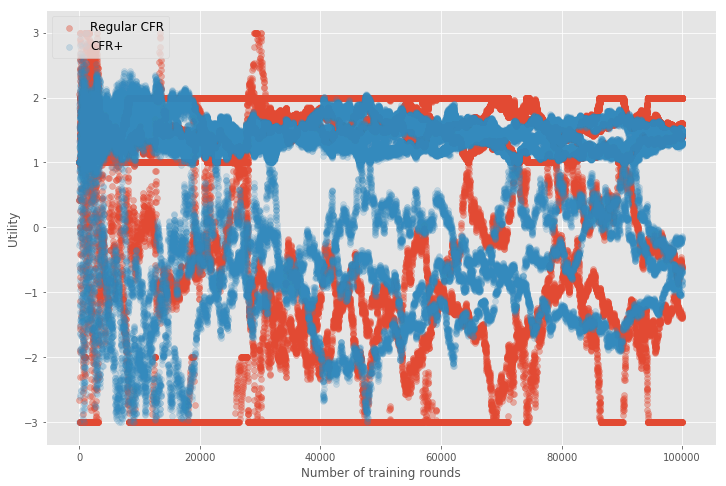

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

ax.scatter(range(1, TRAIN_ROUNDS + 1), 
           l_trainer.utility_history, 
           label='Regular CFR', alpha=0.4)
ax.scatter(range(1, TRAIN_ROUNDS + 1), 
           l_cfr_plus_trainer.utility_history, 
           label='CFR+', alpha=0.2)

ax.legend(loc=2, fontsize=12)
ax.set_xlabel('Number of training rounds', size=12)
ax.set_ylabel('Utility', size=12)

plt.show()

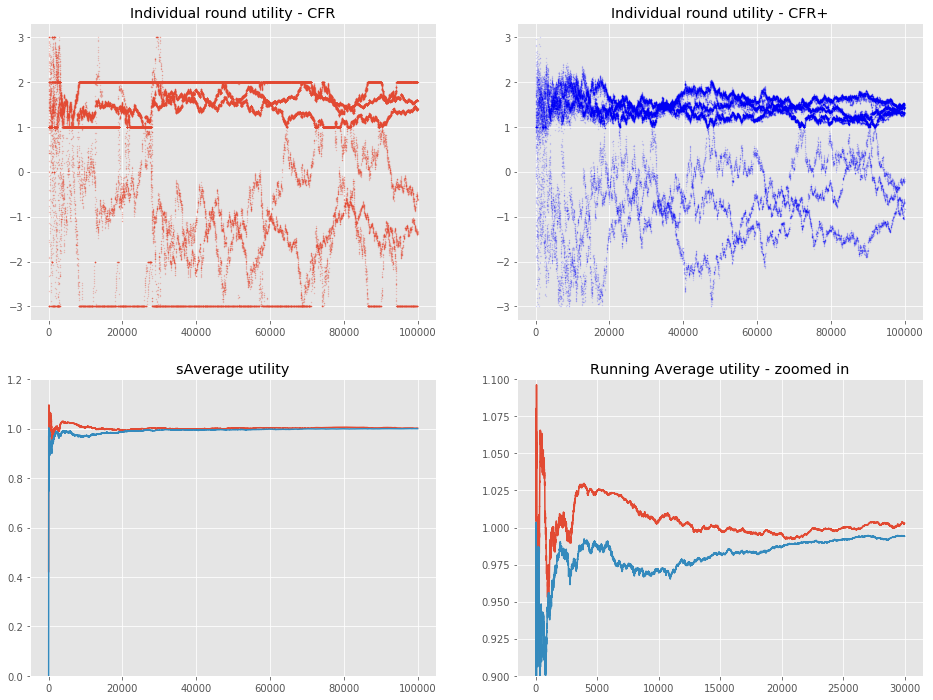

In [18]:
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, hspace=0.2)


top_left_ax = plt.subplot(gs[0, 0])    
top_left_ax.scatter(range(1, TRAIN_ROUNDS + 1), 
                    l_trainer.utility_history, 
                    label='Regular CFR', alpha=0.2, s=1)
top_left_ax.set_title('Individual round utility - CFR')

top_right_ax = plt.subplot(gs[0, 1])
top_right_ax.scatter(range(1, TRAIN_ROUNDS + 1), 
                     l_cfr_plus_trainer.utility_history, 
                     color='blue', alpha=0.1, s=1)
top_right_ax.set_title('Individual round utility - CFR+')

def running_average(data):
    avg = [data[0]]
    for i, d in enumerate(data):
        if i == 0:
            continue
            
        avg.append((avg[-1] * i + d) / (i + 1))
        
    return avg
        
regular_running_average = running_average(l_trainer.utility_history)
cfr_plus_running_average = running_average(l_cfr_plus_trainer.utility_history)
    
bottom_left_ax = plt.subplot(gs[1, 0])
bottom_left_ax.plot(range(1, TRAIN_ROUNDS + 1), 
                    regular_running_average,
                    label='Regular CFR')
bottom_left_ax.plot(range(1, TRAIN_ROUNDS + 1), 
                    cfr_plus_running_average, 
                    label='CFR+')
bottom_left_ax.set_title('sAverage utility')    
bottom_left_ax.set_ylim((0, 1.2))

ZOOMED_MAX = int(3e4)

bottom_right_ax = plt.subplot(gs[1, 1])
bottom_right_ax.plot(range(1, ZOOMED_MAX + 1), 
                    regular_running_average[:ZOOMED_MAX],
                    label='Regular CFR')
bottom_right_ax.plot(range(1, ZOOMED_MAX + 1), 
                    cfr_plus_running_average[:ZOOMED_MAX], 
                    label='CFR+')
bottom_right_ax.set_title('Running Average utility - zoomed in')    
bottom_right_ax.set_ylim((0.9, 1.1))

plt.show()

In [12]:
DIFF_THRESHOLD = 0.33

results = []
for info_set in sorted(l_trainer.nodes):
    info_set_out = info_set.replace('0|', '(J)').replace('1|', '(Q)').replace('2|', '(K)')
    
    cfr_probs = l_trainer.nodes[info_set].get_average_strategy()
    cfr_plus_probs = l_cfr_plus_trainer.nodes[info_set].get_average_strategy()
    
    pass_diff = cfr_plus_probs[0] - cfr_probs[0]
    if abs(pass_diff) > DIFF_THRESHOLD: 
        fmt = 'textbf{{{diff:.3f}}}'
    else:
        fmt = '{diff:.3f}'
    pass_diff = fmt.format(diff=pass_diff)
    
    bet_diff = cfr_plus_probs[1] - cfr_probs[1]
    bet_diff = fmt.format(diff=bet_diff)
    
    
    results.append((info_set_out, cfr_probs[0], cfr_probs[1], 
                    cfr_plus_probs[0], cfr_plus_probs[1],
                    pass_diff, bet_diff))


header = ('Information set', 'CFR P(Pass)', 'CFR P(Bet)', 'CFR+ P(Pass)', 'CFR+ P(Pass)',
         'Delta P(Pass)', 'Delta P(Bet)')

latex_table = tabulate.tabulate(results, header, tablefmt='latex', floatfmt='.3f')
latex_table = latex_table.replace('textbf', '\\textbf').replace('\\{', '{').replace('\\}', '}')
print(latex_table)



\begin{tabular}{lrrrrll}
\hline
 Information set   &   CFR P(Pass) &   CFR P(Bet) &   CFR+ P(Pass) &   CFR+ P(Pass) & Delta P(Pass)   & Delta P(Bet)   \\
\hline
 (J)               &         0.000 &        1.000 &          0.001 &          0.999 & 0.001           & -0.001         \\
 (J)b              &         0.105 &        0.895 &          0.396 &          0.604 & 0.291           & -0.291         \\
 (J)bb(J)          &         0.929 &        0.071 &          0.558 &          0.442 & \textbf{-0.371}  & \textbf{0.371}  \\
 (J)bb(J)b         &         0.000 &        1.000 &          0.000 &          1.000 & 0.000           & -0.000         \\
 (J)bb(J)p         &         0.000 &        1.000 &          0.000 &          1.000 & 0.000           & -0.000         \\
 (J)bb(J)pb        &         0.000 &        1.000 &          0.000 &          1.000 & -0.000          & 0.000          \\
 (J)bb(Q)          &         0.000 &        1.000 &          0.013 &          0.987 & 0.013           & -